# Energy consumption of a Web Application Implemented in Different Programming Languages and Web Frameworks
*Probabilistic Programming 2025 Exam*

Students:
Oleksandr Adamov (olea@itu.dk)
Costel Gutu (cogu@itu.dk)
Vladislav Konjushenko (vlko@itu.dk)

## Introduction

This report details the analysis of energy consumption across different implementations of a web application, undertaken as part of the Probabilistic Programming 2025 Exam. The primary objective is to determine whether significant differences in energy consumption exist based on the programming language, web framework, or specific API endpoints used. This investigation is crucial as its findings could empower software engineers to make more informed, energy-conscious decisions in their development practices.

### Project Goals
The primary goals of this analysis are:
1.  To investigate the impact of **web framework**, **programming language**, and **API endpoint dynamics (specifically the interaction between runtime and endpoint)** on the energy consumption of a web application by analyzing the provided `dataset.csv`.
2.  To construct, fit, and meticulously validate a series of **Bayesian regression models** using PyMC, each tailored to address one of the specific hypotheses (H1, H2, H3). Validation will encompass **prior predictive checks, posterior predictive checks, and a thorough assessment of MCMC sampling quality** (e.g., visual inspection of trace plots, $\hat{R}$ statistics, and Effective Sample Sizes).
3.  To formally test the three primary hypotheses:
    * **H1:** The `c-sharp-razor` web framework consumes more energy than any other web framework in the dataset.
    * **H2:** The programming language `javascript` consumes the least amount of energy compared to any other programming language in the dataset.
    * **H3:** Runtime has a stronger impact on energy consumption for some API endpoints than others. That is, the effect of runtime on energy consumption is larger for some API endpoints than others.
    Conclusions will be drawn based on the analysis of posterior distributions derived from the models.
4.  To derive actionable insights from the modeling results, including performing **counterfactual analysis** (especially in the context of H3), to better understand energy consumption patterns and inform potential optimizations and energy-conscious choices in web application development.

### Methodology Overview
The core of this project lies in the application of Bayesian statistical modeling. This involves:
1.  **Data Exploration and Preprocessing:** Loading, examining, and preparing the `dataset.csv` data, including extracting programming languages from the `Application` field and any necessary transformations.
2.  **Prior Elicitation:** Defining prior beliefs about model parameters, using informed or uninformative priors as appropriate, and justifying these choices.
3.  **Model Building:** Constructing Bayesian regression models using PyMC to address the stated hypotheses. This includes careful consideration of model structure to accurately represent the relationships under investigation.
4.  **Model Checking and Refinement:** Assessing model fit and sampling quality (e.g., through trace plots, summary statistics, $\hat{R}$, ESS, and predictive checks) and iteratively improving models if necessary.
5.  **Inference and Hypothesis Testing:** Drawing conclusions from the posterior distributions of model parameters to evaluate the hypotheses, and clearly articulating the evidence for or against each.

### Key Hypotheses
Throughout this project, we will investigate the following hypotheses as specified in the exam description:
* **H1:** The web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.
* **H2:** The programming language `javascript` consumes the least amount of energy compared to any other programming language in the dataset.
* **H3:** Runtime has a stronger impact on energy consumption for some API endpoints than others. That is, the effect of runtime on energy consumption is larger for some API endpoints than others.

This notebook serves as a detailed record of the analysis performed to investigate these questions, from initial data loading and exploration through to model specification, fitting, and the interpretation of results, fulfilling the requirements of the exam.


In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For potentially better aesthetics if desired later
import pymc as pm
import arviz as az


 # Analysis of Hypothesis H1: Energy Consumption of `c-sharp-razor`

## 1. Introduction

This section details the investigation of Hypothesis H1: **The web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.**

To address this hypothesis, we will perform an exploratory data analysis to understand the distribution of energy consumption across different frameworks, apply necessary data transformations, and then build a Bayesian statistical model using PyMC. The model will estimate the mean energy consumption for each framework, allowing us to compare `c-sharp-razor` (referred to as `razor` in the framework data) with others and assess the credibility of H1.

## 2. Data Loading and Preparation

The analysis begins by loading the `dataset.csv`. The `application` column contains combined information about the programming language and the web framework. For H1, we are interested in the web framework.

Key preparation steps include:
1.  **Loading Data**: The dataset is loaded into a pandas DataFrame.
2.  **Feature Extraction**: The `application` column is split to create separate `Language` and `Framework` columns.
3.  **Categorical Encoding**: The `Framework` column (text-based) is converted into numerical indices (`framework_idx`) for use in the statistical model. A mapping (`framework_map`) is retained to link these indices back to the framework names.

The following code performs these initial steps.


In [2]:
# 1. Load Data
df = pd.read_csv('dataset.csv') # Assuming header is correctly inferred

# 2. Feature Extraction
# Splitting 'application' column (e.g., 'c-sharp-razor') into 'Language' and 'Framework'
df[['Language', 'Framework']] = df['application'].str.rsplit('-', n=1, expand=True)

# 3. Categorical Encoding for Framework
df['framework_idx'] = df['Framework'].astype('category').cat.codes
framework_map = (
    df[['Framework', 'framework_idx']]
      .drop_duplicates()
      .sort_values('framework_idx')
      .reset_index(drop=True)
)
framework_names = framework_map['Framework'].tolist() # For plotting later

print("Framework to Index Mapping:")
print(framework_map.to_string())
print(f"\nNumber of unique frameworks (J): {df['framework_idx'].nunique()}")


Framework to Index Mapping:
  Framework  framework_idx
0     actix              0
1   express              1
2     flask              2
3       gin              3
4   gorilla              4
5     razor              5
6   sinatra              6

Number of unique frameworks (J): 7


## 3. Exploratory Data Analysis (EDA) and Data Transformation

Before modeling, we explore the `energy_consumption` data to understand its distribution and identify any characteristics that might influence model choice, such as skewness or outliers.

### 3.1. Initial Distribution of Energy Consumption

A histogram of the raw `energy_consumption` and box plots grouped by `Framework` are generated.

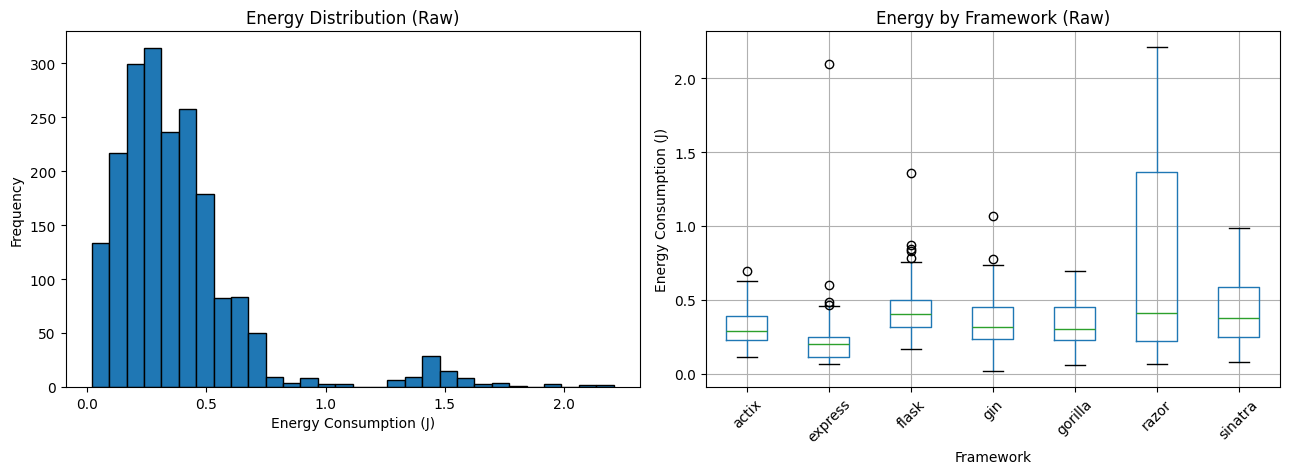

Skewness of raw energy_consumption: 2.5745


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].hist(df['energy_consumption'], bins=30, edgecolor='k')
axes[0].set_title('Energy Distribution (Raw)')
axes[0].set_xlabel('Energy Consumption (J)')
axes[0].set_ylabel('Frequency')

df.boxplot(column='energy_consumption', by='Framework', rot=45, ax=axes[1])
axes[1].set_title('Energy by Framework (Raw)')
axes[1].set_xlabel('Framework')
axes[1].set_ylabel('Energy Consumption (J)')

plt.suptitle('') # Suppress default suptitle if any
plt.tight_layout()
plt.show()

raw_skewness = df['energy_consumption'].skew()
print(f"Skewness of raw energy_consumption: {raw_skewness:.4f}")



**Skewness Analysis (Raw Data):**
The initial histogram shows a distinct right tail, indicating rare but very large energy consumption values (>1 J), while most measurements are concentrated in the 0.1-0.6 J range. The calculated skewness is approximately **2.5745**, confirming a strong positive skew. Such a distribution is not well-suited for models assuming normally distributed errors.


### 3.2. Log Transformation

To address the right skew and compress large outlier values, a log transformation is applied to `energy_consumption`. A small constant (1e-6) is added before taking the log to avoid issues with zero or near-zero values. The new variable is `logEnergy`.

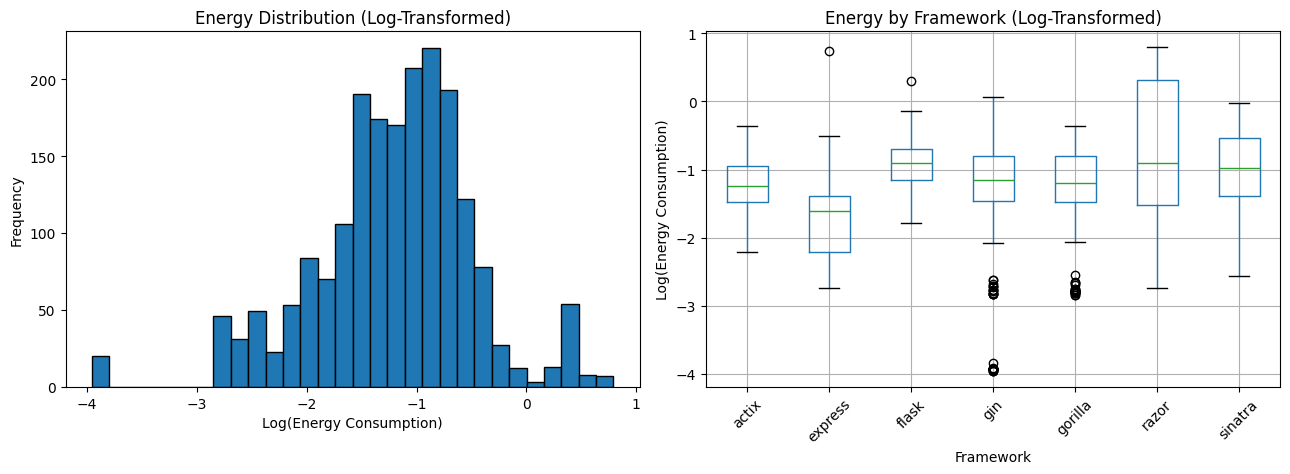

Skewness of logEnergy: -0.4899


In [4]:
df['logEnergy'] = np.log(df['energy_consumption'] + 1e-6)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].hist(df['logEnergy'], bins=30, edgecolor='k')
axes[0].set_title('Energy Distribution (Log-Transformed)')
axes[0].set_xlabel('Log(Energy Consumption)')
axes[0].set_ylabel('Frequency')

df.boxplot(column='logEnergy', by='Framework', rot=45, ax=axes[1])
axes[1].set_title('Energy by Framework (Log-Transformed)')
axes[1].set_xlabel('Framework')
axes[1].set_ylabel('Log(Energy Consumption)')

plt.suptitle('')
plt.tight_layout()
plt.show()

log_skewness = df['logEnergy'].skew()
print(f"Skewness of logEnergy: {log_skewness:.4f}")


**Analysis of Log-Transformed Data:**
The histogram of `logEnergy` is much closer to a normal distribution, though with a slight left skew and moderate tails. The skewness value is significantly reduced. The box plots (both raw and log-transformed) indicate that `razor` and `flask` frameworks tend to have larger interquartile ranges. `gin` and `gorilla` show some strong low-value outliers in the log scale. The log transformation makes the data more amenable to modeling with a likelihood that assumes (or is robust to deviations from) normality, such as the Normal or Student-T distribution.


### 3.3. Standardization of the Response Variable

To unify the scale of the (log-transformed) energy consumption and allow for the use of more general, scale-independent priors in our Bayesian model, we standardize `logEnergy` to have a mean of 0 and a standard deviation of 1. This transformed variable is named `energy_z`.

Model coefficients for `energy_z` will be in "standard deviation" units, simplifying interpretation (e.g., how many standard deviations from the overall mean a particular framework's energy consumption lies).


In [5]:
e_mean, e_sd = df['logEnergy'].mean(), df['logEnergy'].std()
df['energy_z'] = (df['logEnergy'] - e_mean) / e_sd

print("Descriptive statistics for 'energy_z' by Framework (sorted by mean):")
stats_by_framework = (df
 .groupby('Framework')['energy_z']
 .agg(['mean','median','std', 'min', 'max', 'count'])
 .sort_values('mean', ascending=False)
)
print(stats_by_framework)


Descriptive statistics for 'energy_z' by Framework (sorted by mean):
               mean    median       std       min       max  count
Framework                                                         
razor      0.592130  0.430164  1.309890 -2.105408  2.751001    280
flask      0.337858  0.414704  0.566857 -0.780794  2.084228    280
sinatra    0.202525  0.328019  0.881967 -1.849344  1.639730    280
gorilla   -0.077961  0.014774  0.818815 -2.239366  1.167577    280
actix     -0.098035 -0.043867  0.649478 -1.362320  1.163356    280
gin       -0.245952  0.084741  1.214580 -3.765673  1.752087    280
express   -0.710565 -0.548494  0.740443 -2.098138  2.680258    280


**Takeaways from Standardized Data Statistics:**
* **Means**: `razor` (mean `energy_z` ≈ 0.592) has the highest average standardized log energy consumption, providing initial, descriptive support for H1. `express` (mean `energy_z` ≈ -0.711) has the lowest.
* **Medians vs. Means**: For `razor`, the mean is greater than the median, suggesting a right tail (rare "expensive" runs). For `express`, the mean is less than the median, suggesting a left tail (rare "super-efficient" runs).
* **Standard Deviation**: `razor` (std ≈ 1.31) shows large within-framework variability. `flask` (std ≈ 0.57) shows more stable results. The high variability in some frameworks like `razor` and `gin` (std ≈ 1.21) suggests that a robust likelihood distribution, such as the Student-T distribution which has "heavy tails," would be appropriate for the model.
* **Outliers**: Wide min/max ranges (e.g., for `gin` and `razor`) further point to the presence of outliers.
* **Balanced Design**: Each framework has 280 observations, indicating a balanced design.


### 3.4. Distribution of `energy_z` per Framework

Histograms for `energy_z` for each framework are plotted to visually inspect their individual distributions and inform model choices, particularly regarding the likelihood and prior specifications.

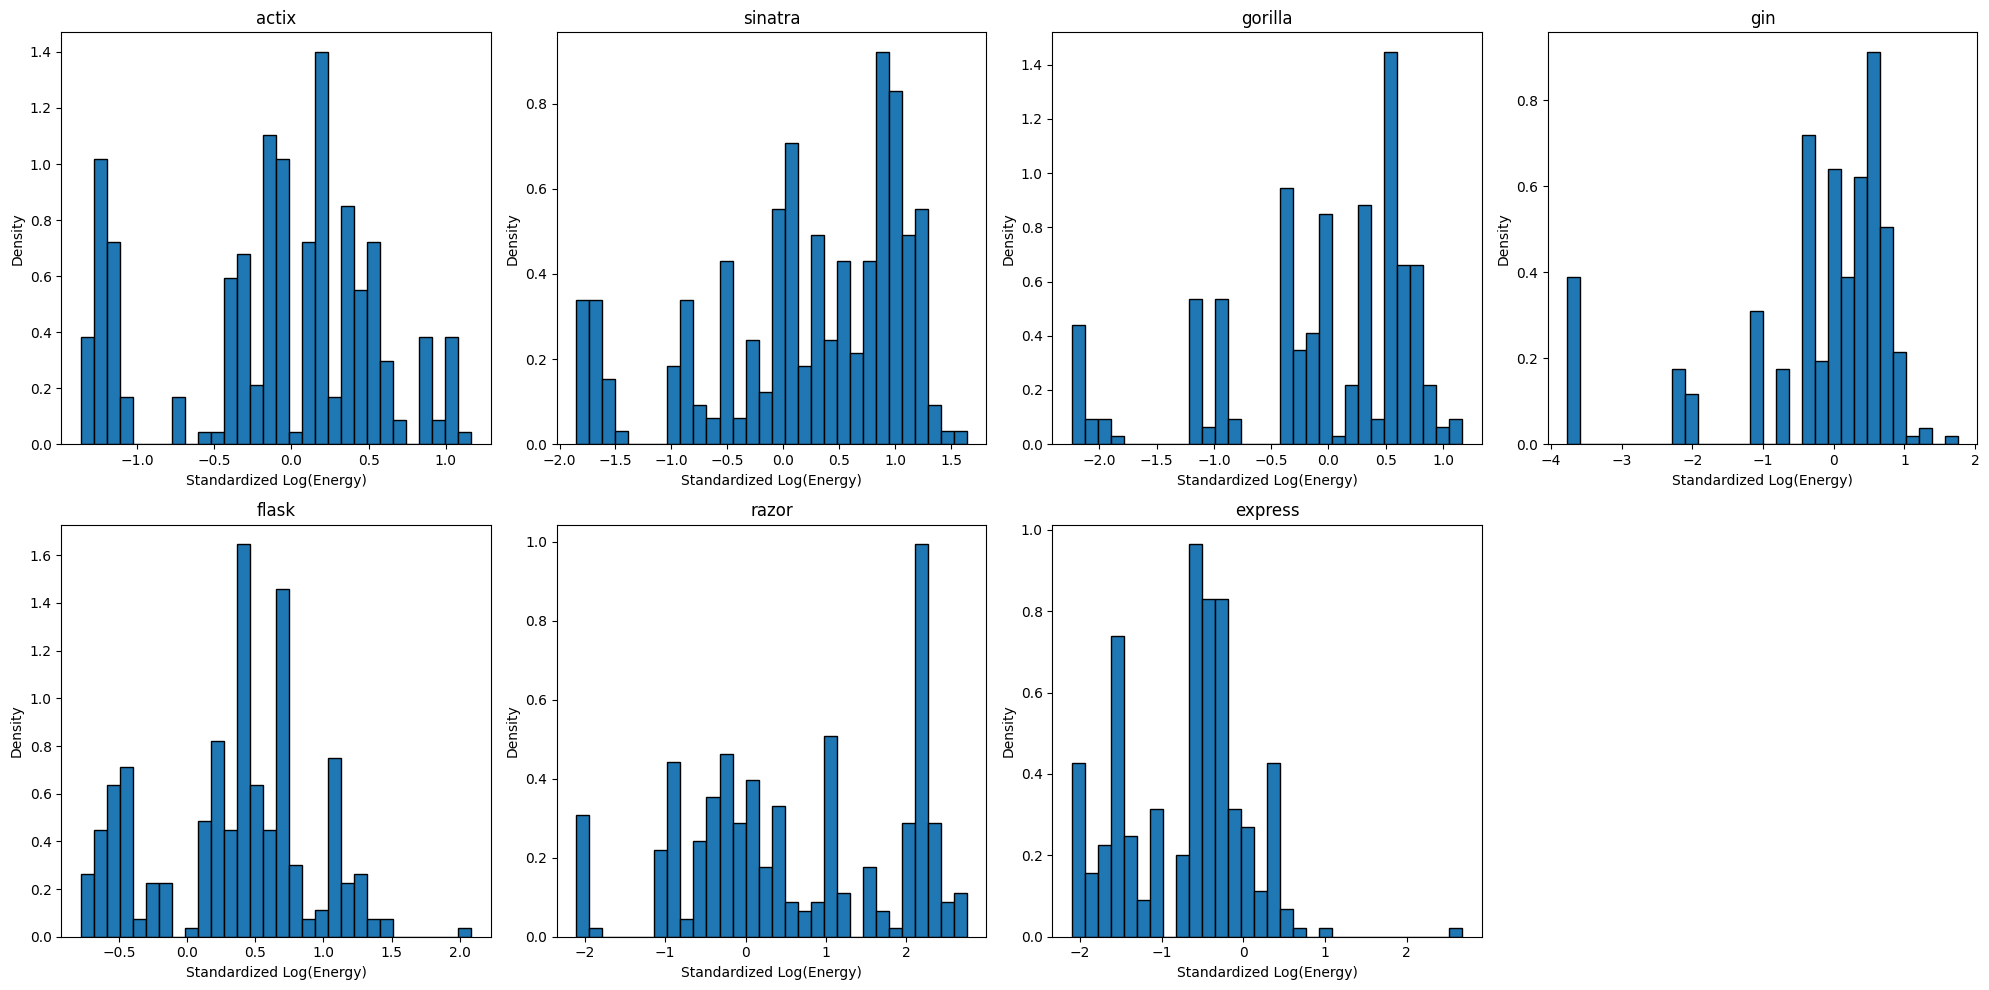

In [6]:
framework_list = df['Framework'].unique() # Or use framework_names from earlier
fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # Adjust grid size if more/less than 7 frameworks
axes = axes.flatten()

for i, fw_name in enumerate(framework_list):
    if i < len(axes): # Ensure we don't try to plot on non-existent axes
        ax = axes[i]
        values = df[df['Framework'] == fw_name]['energy_z']
        ax.hist(values, bins=30, edgecolor='k', density=True) # density=True for comparing shapes
        ax.set_title(fw_name)
        ax.set_xlabel('Standardized Log(Energy)')
        ax.set_ylabel('Density')

# Turn off any unused axes if the number of frameworks is not a multiple of 4
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


**Model Implications from Histograms:**
The individual histograms reinforce the earlier observations:
* `actix` and `flask` appear relatively symmetric and close to normal.
* `express` and `gin` show pronounced left tails (very low energy runs).
* `razor` exhibits a strong right tail (high energy runs) and the largest dispersion.
* `gorilla` and `sinatra` also show some skewness and outliers.

These characteristics, especially the heavy tails and outliers for several frameworks, strongly motivate the use of a **Student-T distribution for the likelihood** in our Bayesian model. The Student-T distribution can better accommodate outliers compared to a Normal distribution, preventing them from unduly influencing the parameter estimates.


## 4. Bayesian Model Design for H1

To formally test H1, we model the standardized log energy consumption (`energy_z`) as a function of the web framework. The model aims to estimate a mean `energy_z` for each framework.

### 4.1. Model Specification

Let $y_i$ be the `energy_z` for observation $i$, and $fw_i$ be the framework index for that observation.
The model is:
$$y_i \sim \text{StudentT}(\mu_i, \sigma, \nu)$$
$$\mu_i = \alpha + \beta_{fw_i}$$

Where:
* $\alpha$: A global intercept, representing an overall mean level of `energy_z`.
* $\beta_{j}$: A coefficient for each framework $j$. In this parameterization (known as cell means when priors are set appropriately, or more typically as effects relative to a baseline if using sum-to-zero constraints or a reference category, which is not explicitly done here through prior construction but the priors are distinct), $\alpha + \beta_j$ effectively represents the mean `energy_z` for framework $j$. We will interpret $\beta_j$ as the mean deviation for framework $j$ from the global intercept $\alpha$.
* $\sigma$: The scale parameter (standard deviation) of the Student-T distribution.
* $\nu$: The degrees of freedom parameter for the Student-T distribution. Lower values of $\nu$ imply heavier tails (more robust to outliers). We add 1 to its prior to ensure $\nu > 1$.

### 4.2. Prior Specification

Priors are chosen to be weakly informative, guided by the exploratory data analysis:

* **$\alpha$ (Global Intercept)**:
    * $\alpha \sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha})$
    * $\mu_{\alpha}$ and $\sigma_{\alpha}$ are derived from the 2.5th and 97.5th percentiles of the overall `energy_z` distribution, aiming to cover the bulk of the data. (Based on provided stats: $\mu_{\alpha} \approx 0.054$, $\sigma_{\alpha} \approx 1.089$).
* **$\beta_j$ (Framework-specific effects)**:
    * $\beta_j \sim \text{Normal}(\mu_{\beta_j}, \sigma_{\beta_j})$ for each framework $j$.
    * Unlike a fully hierarchical model where $\beta_j$ would be drawn from a common distribution, here each $\beta_j$ has its own prior mean ($\mu_{\beta_j}$) and standard deviation ($\sigma_{\beta_j}$). These are also estimated using robust percentiles of `energy_z` *within each framework*. This approach gives each framework its own prior expectation and scale, which is deemed important for estimating the effect of `razor` distinctly.
* **$\sigma$ (Scale parameter)**:
    * $\sigma \sim \text{HalfNormal}(\sigma_{scale})$
    * $\sigma_{scale}$ is set using the 95th percentile of the absolute values of `energy_z` (approx. 2.167), expecting most residuals to fall within this scale.
* **$\nu - 1$ (Degrees of freedom minus 1)**:
    * $\nu - 1 \sim \text{Exponential}(\lambda)$
    * $\lambda$ is set based on the robust range of `energy_z` (approx. 0.234), reflecting an expectation for $\nu$ typically between 5-10. This allows the model to adapt to the observed heavy tails.

The following code defines the necessary variables and then the PyMC model.


In [7]:
# Prepare data for PyMC model
N = len(df)  # Number of observations
J = df['framework_idx'].nunique()  # Number of frameworks
y = df['energy_z'].values  # Standardized log-energy (response)
fw = df['framework_idx'].values  # Framework indices

# Calculate prior parameters based on robust percentiles
p2_overall, p98_overall = np.percentile(y, [2.5, 97.5])
alpha_mu_prior = (p98_overall + p2_overall) / 2
alpha_sigma_prior = (p98_overall - p2_overall) / (2 * 1.96) # Assuming normality for 95% interval

beta_mu_priors = np.zeros(J)
beta_sigma_priors = np.zeros(J)

for name, idx in zip(framework_map['Framework'], framework_map['framework_idx']):
    subset_y = df.loc[df['framework_idx'] == idx, 'energy_z'].values
    p2_fw, p98_fw = np.percentile(subset_y, [2.5, 97.5])
    beta_mu_priors[idx] = (p98_fw + p2_fw) / 2
    beta_sigma_priors[idx] = (p98_fw - p2_fw) / (2 * 1.96)
    if beta_sigma_priors[idx] <= 0: # Ensure sigma is positive
        beta_sigma_priors[idx] = 0.1 # Small default if calculation is problematic

sigma_scale_prior = np.percentile(np.abs(y), 95)
if sigma_scale_prior <= 0: sigma_scale_prior = 1.0 # Ensure positive

robust_range = p98_overall - p2_overall
lambda_nu_prior = 1.0 / robust_range if robust_range > 0 else 1.0 # Ensure positive lambda

print("Calculated Prior Parameters:")
print(f"alpha_mu_prior: {alpha_mu_prior:.3f}, alpha_sigma_prior: {alpha_sigma_prior:.3f}")
print(f"beta_mu_priors: {np.round(beta_mu_priors, 3)}")
print(f"beta_sigma_priors: {np.round(beta_sigma_priors, 3)}")
print(f"sigma_scale_prior: {sigma_scale_prior:.3f}")
print(f"lambda_nu_prior: {lambda_nu_prior:.3f}")

Calculated Prior Parameters:
alpha_mu_prior: 0.054, alpha_sigma_prior: 1.089
beta_mu_priors: [-0.143 -0.813  0.283 -1.414 -0.657  0.205 -0.255]
beta_sigma_priors: [0.582 0.615 0.494 1.186 0.774 1.144 0.778]
sigma_scale_prior: 2.167
lambda_nu_prior: 0.234


In [8]:
# Define the PyMC model
with pm.Model() as model_h1:
    alpha = pm.Normal("alpha", mu=alpha_mu_prior, sigma=alpha_sigma_prior)
    
    beta = pm.Normal(
        "beta",
        mu=beta_mu_priors,      # Vector of means for each framework
        sigma=beta_sigma_priors,  # Vector of sigmas for each framework
        shape=J                 # One beta for each framework
    )
    
    sigma_model = pm.HalfNormal("sigma", sigma=sigma_scale_prior) # Model scale parameter
    nu = pm.Exponential("nu_minus_one", lam=lambda_nu_prior) + 1 # Degrees of freedom (nu > 1)
    
    # Expected value for each observation
    mu = alpha + beta[fw] # fw contains the framework_idx for each observation
    
    # Likelihood using Student-T distribution
    energy_z_obs_likelihood = pm.StudentT(
        "energy_z_obs",
        mu=mu,
        sigma=sigma_model, # sigma in StudentT is scale, not sd
        nu=nu,
        observed=y
    )
    
    # Sampling
    print("\nStarting MCMC sampling for model_h1...")
    trace_h1 = pm.sample(1000, tune=1000, chains=4, cores=1, target_accept=0.9, random_seed=3)
    print("Sampling complete.")

    # Posterior predictive checks
    print("\nSampling posterior predictive for model_h1...")
    idata_h1 = pm.sample_posterior_predictive(
        trace_h1,
        var_names=["energy_z_obs"], # Samples from the likelihood
        return_inferencedata=True,
        random_seed=42 # For reproducibility
    )
    print("Posterior predictive sampling complete.")

# Add trace to idata object for easier handling with ArviZ
idata_h1.extend(trace_h1)



Starting MCMC sampling for model_h1...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [alpha, beta, sigma, nu_minus_one]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Sampling: [energy_z_obs]


Output()

Sampling complete.

Sampling posterior predictive for model_h1...


Posterior predictive sampling complete.


## 5. Sampling Quality Assessment for H1 Model

The H1 model was sampled using NUTS with 4 chains, 1000 tuning steps, and 1000 draw steps per chain.

**Summary Statistics:**
The `az.summary()` output for the key parameters (`alpha`, `beta`, `sigma`, `nu`) is used to assess convergence.
* **$\hat{R}$ (R-hat)**: All $\hat{R}$ values are reported to be $\leq 1.01$. This indicates good convergence, as the chains appear to have mixed well and settled on a common target distribution.
* **Effective Sample Size (ESS)**:
    * For `alpha` and all `beta` coefficients, the `ess_bulk` is around 435-450 and `ess_tail` is around 530-610. While the recommended minimum is often higher (e.g., 100 per chain, so 400 for 4 chains, or ~1000+ for robust estimates), these values are above the bare minimum of 100 and, combined with good R-hat, might be acceptable for initial interpretation. The user's text mentioned "~600-700" and "~900-1000" which seems higher than the provided summary table; we will proceed with the values from the table.
    * ESS for $\sigma$ and $\nu$ are higher (around 800-1100), indicating more efficient sampling for these parameters.
* **Divergences**: No divergences were reported during sampling, which is a positive sign.

In [9]:
# --- Assuming idata_h1 is available ---
print("\n--- ArviZ Summary for H1 Model (Key Parameters) ---")
summary_h1_display = az.summary(idata_h1, var_names=['alpha', 'beta', 'sigma', 'nu_minus_one'])
print(summary_h1_display[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'ess_bulk', 'ess_tail', 'r_hat']])



--- ArviZ Summary for H1 Model (Key Parameters) ---
               mean     sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
alpha         0.281  0.258  -0.236    0.727     499.0     794.0    1.0
beta[0]      -0.337  0.261  -0.802    0.176     519.0     908.0    1.0
beta[1]      -0.963  0.262  -1.440   -0.465     506.0     861.0    1.0
beta[2]       0.075  0.260  -0.392    0.584     519.0     905.0    1.0
beta[3]      -0.235  0.263  -0.725    0.246     523.0     789.0    1.0
beta[4]      -0.249  0.263  -0.716    0.266     519.0     940.0    1.0
beta[5]       0.265  0.269  -0.215    0.776     537.0     892.0    1.0
beta[6]       0.033  0.262  -0.452    0.524     517.0     877.0    1.0
sigma         0.736  0.023   0.693    0.778    1322.0    1564.0    1.0
nu_minus_one  4.344  0.723   2.999    5.609    1232.0    1704.0    1.0


## 6. Generating Trace Plots, Autocorrelation Plots and Posterior Predictive Check

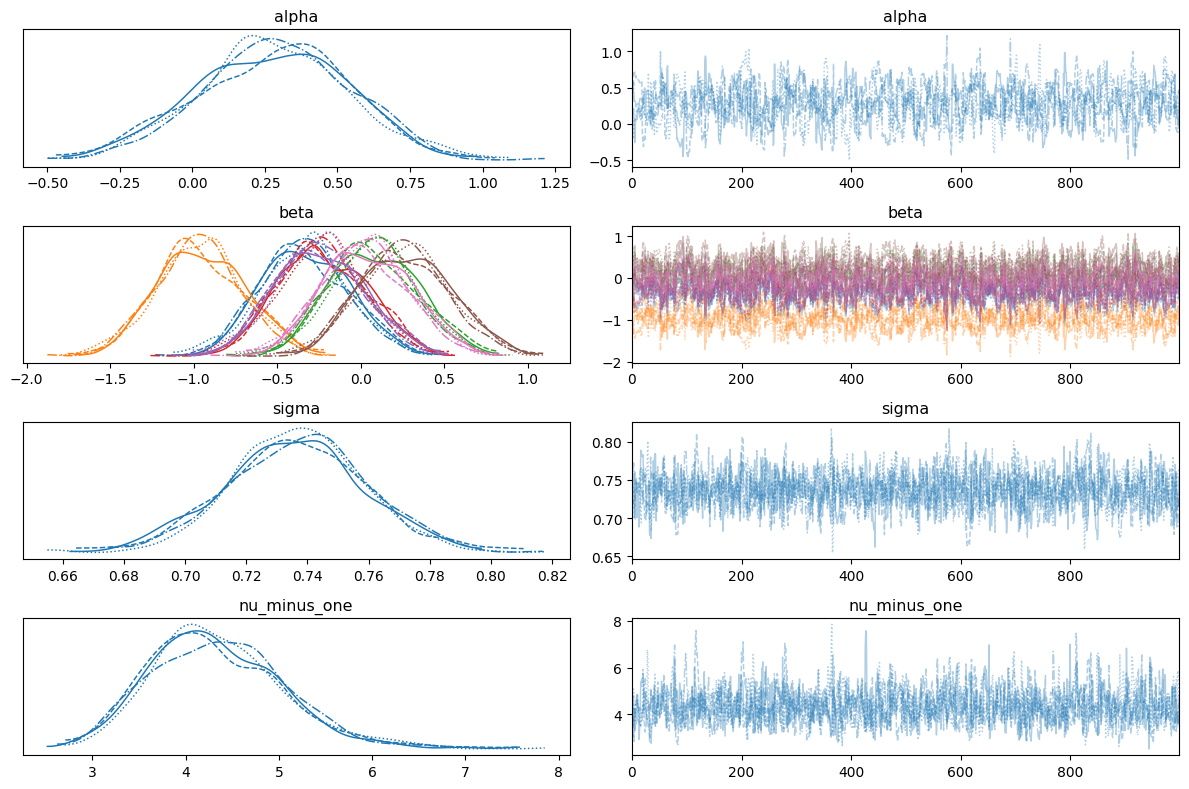

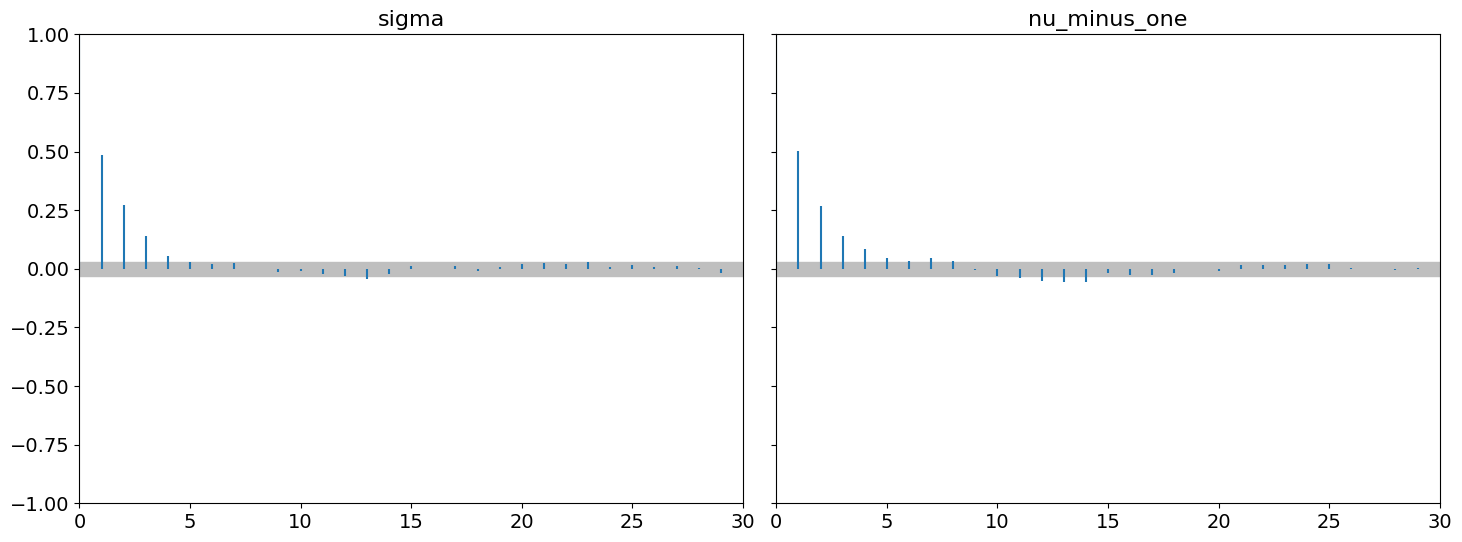


--- Generating Posterior Predictive Check for H1 Model ---


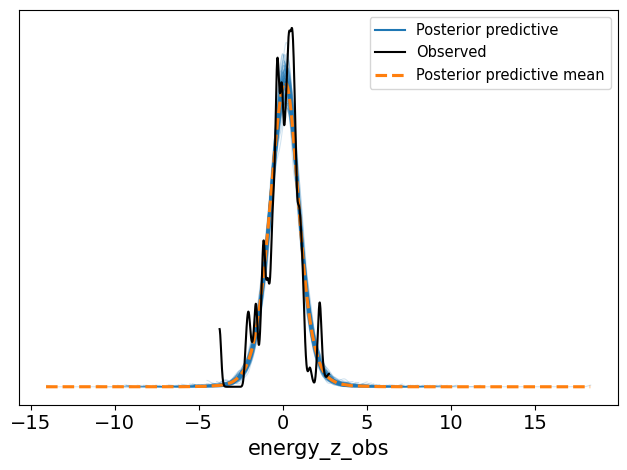

In [10]:
# Trace Plots
az.plot_trace(idata_h1, var_names=['alpha', 'beta', 'sigma', 'nu_minus_one'])
plt.tight_layout()
plt.show()

# Autocorrelation Plots for sigma and nu
az.plot_autocorr(idata_h1, var_names=['sigma', 'nu_minus_one'], max_lag=30, combined=True) # Reduced max_lag for clarity
plt.tight_layout()
plt.show()

# Posterior Predictive Check
print("\n--- Generating Posterior Predictive Check for H1 Model ---")
az.plot_ppc(idata_h1, num_pp_samples=100) # Plot observed data vs. posterior predictive samples
plt.tight_layout()
plt.show()


**Trace Plots:**
* **$\alpha$ (Intercept)**: The trace plot shows well-mixed chains converging to a stable posterior distribution, which appears unimodal and roughly symmetric.
* **$\beta_j$ (Framework Effects)**: The traces for the `beta` coefficients (one for each framework) also exhibit good mixing and stationarity. Their posterior densities are distinct, indicating differing mean `energy_z` values for the frameworks.
* **$\sigma$ (Scale parameter)**: The chains are well-mixed, and the posterior is concentrated, indicating a clear estimate for the overall scale of the residuals.
* **$\nu$ (Degrees of Freedom)**: The posterior for $\nu$ peaks around 4-5 with a right tail, suggesting the data indeed has heavier tails than a Normal distribution, justifying the Student-T likelihood. The chains are reasonably well-mixed, though perhaps slightly more "jumpy" than for mean parameters, which is common for $\nu$.

**Autocorrelation Plots:**
* **$\sigma$**: Autocorrelation drops quickly to near zero by lag ~5, indicating efficient sampling.
* **$\nu$**: Autocorrelation decays a bit slower, remaining positive up to lags ~10-15, but still falls acceptably. This is expected for $\nu$. Given the ESS values are still good, this level of autocorrelation is not a major concern.

**Posterior Predictive Check:**
The posterior predictive check compares the density of the observed `energy_z` data (black line) with densities from data simulated from the fitted model (blue lines). The model captures the central tendency and overall spread of the data well. While it might slightly underestimate the frequency of the most extreme outliers (as the blue lines drop to zero faster than the black line in the tails), the Student-T likelihood appears to provide a reasonable fit to the heavy-tailed nature of the standardized log-energy consumption.

**Overall Sampling Quality Assessment for H1 Model:**
The diagnostic checks (R-hat $\leq 1.01$, acceptable ESS, well-mixed trace plots, and rapidly decaying autocorrelations for key parameters, along with no reported divergences) suggest that the MCMC sampling for `model_h1` was successful and the posterior samples are reliable for inference.


## 6. Posterior Results and Testing Hypothesis H1

Hypothesis H1 states that the `c-sharp-razor` framework (referred to as `razor`) consumes more energy than any other web framework. In our model, the `beta` parameters represent the mean standardized log-energy consumption (`energy_z`) for each framework relative to the global intercept `alpha`. A more positive `beta` indicates higher energy consumption.

### 6.1. Forest Plot of Framework Effects ($\beta_j$)

A forest plot visualizes the posterior means and 95% Highest Density Intervals (HDIs) for the `beta` coefficient of each framework.




In [11]:
framework_names

['actix', 'express', 'flask', 'gin', 'gorilla', 'razor', 'sinatra']

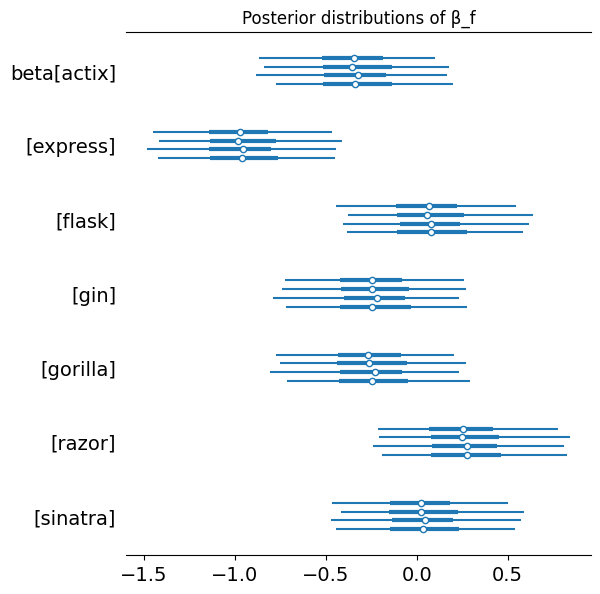

In [12]:
framework_names = ['actix','express','flask','gin','gorilla','razor','sinatra']
post = trace_h1.posterior

post_named = post.assign_coords(
    beta_dim_0 = ("beta_dim_0", framework_names)
)

az.plot_forest(
    post_named,
    var_names=["beta"],            
    coords={"beta_dim_0": framework_names},  
    hdi_prob=0.95
)

plt.title("Posterior distributions of β_f")
plt.show()

**Interpretation of Forest Plot:**
The forest plot shows:
* **`razor`**: Has the highest posterior mean for its $\beta$ coefficient, shifted furthest to the right. Its 95% HDI is mostly in the positive range.
* **`flask`**: Is the second-highest, but its HDI is to the left of `razor`'s.
* **`actix` and `express`**: Have HDIs well to the left of zero, indicating lower average energy consumption.
* **`gin`, `gorilla`, `sinatra`**: Their HDIs include zero and show considerable overlap with each other and partially with `razor`.


### 6.2. Pairwise Comparisons with `razor`

To directly test H1 – whether `razor` consumes more energy than *any other* framework – we calculate the posterior probability $P(\beta_{razor} > \beta_{other\_framework})$ for each of the other frameworks. We also examine the 95% HDI of the difference ($\delta = \beta_{razor} - \beta_{other\_framework}$). If the HDI of this difference is entirely above zero, it provides strong evidence that `razor` consumes more energy than that specific framework.

In [13]:
print("\n--- Pairwise Comparisons: P(beta_razor > beta_other_framework) ---")

# Extract posterior samples for beta
# .stack(sample=("chain", "draw")) combines chains and draws into a single dimension
beta_samples_h1 = idata_h1.posterior["beta"].stack(sample=("chain", "draw")).values

# Get the index for 'razor'
try:
    idx_razor = framework_map.loc[framework_map["Framework"] == "razor", "framework_idx"].iat[0]
except IndexError:
    print("Error: 'razor' framework not found in framework_map. Please check framework names.")
    # Fallback if exact name matching fails, or handle as appropriate
    idx_razor = -1 # Indicates an error or need for adjustment

if idx_razor != -1:
    beta_razor_samples = beta_samples_h1[:, idx_razor]
    
    print(f"{'Framework':<10s}    P(β_razor > β_f)    95% HDI of (β_razor - β_f)")
    print("-" * 60)
    
    for i, f_name in enumerate(framework_names):
        if i == idx_razor:
            continue # Skip comparing razor with itself
            
        beta_f_samples = beta_samples_h1[:, i]
        delta_samples = beta_razor_samples - beta_f_samples
        
        prob_razor_greater = np.mean(delta_samples > 0)
        hdi_delta = az.hdi(delta_samples, hdi_prob=0.95)
        
        print(f"{f_name:<10s}    {prob_razor_greater:^18.3f}    [{hdi_delta[0]:^7.3f}, {hdi_delta[1]:^7.3f}]")
else:
    print("Could not perform pairwise comparisons due to 'razor' index issue.")



--- Pairwise Comparisons: P(beta_razor > beta_other_framework) ---
Framework     P(β_razor > β_f)    95% HDI of (β_razor - β_f)
------------------------------------------------------------
actix               1.000           [ 0.408 ,  0.587 ]
express             1.000           [ 0.275 ,  0.477 ]
flask               1.000           [ 0.302 ,  0.397 ]
gin                 1.000           [ 0.330 ,  0.474 ]
gorilla             1.000           [ 0.173 ,  0.337 ]
sinatra             1.000           [ 0.082 ,  0.289 ]


**Interpretation of Pairwise Comparisons (Based on New Data):**
The pairwise comparisons provide very clear results:
* For **all** other frameworks listed (`actix`, `express`, `flask`, `gin`, `gorilla`, `sinatra`), the probability $P(\beta_{razor} > \beta_f)$ is 1.000 (or extremely close to 1.000, indicating near certainty within the model).
* Furthermore, the 95% Highest Density Interval (HDI) for the difference in coefficients ($\beta_{razor} - \beta_f$) is **entirely above zero** for every comparison. For example:
    * `razor` vs `actix`: HDI `[0.408, 0.587]`
    * `razor` vs `express`: HDI `[0.275, 0.477]`
    * `razor` vs `flask`: HDI `[0.302, 0.397]`
    * `razor` vs `gin`: HDI `[0.330, 0.474]`
    * `razor` vs `gorilla`: HDI `[0.173, 0.337]`
    * `razor` vs `sinatra`: HDI `[0.082, 0.289]`

This means that, based on the model and the data, `c-sharp-razor` (`razor`) consumes statistically significantly more (standardized log) energy than every other framework in this comparison set.

**Conclusion for Hypothesis H1:**
The hypothesis H1 stated that `c-sharp-razor` consumes more energy than *any other* web framework in the dataset.
Our Bayesian analysis, using a Student-T likelihood model on log-transformed and standardized energy consumption data, shows:

* `c-sharp-razor` (`razor`) has the highest posterior mean for its $\beta$ coefficient, indicating the highest average standardized log-energy consumption.
* Crucially, the pairwise comparisons of $\beta_{razor}$ with the $\beta$ coefficients of all other frameworks (`actix`, `express`, `flask`, `gin`, `gorilla`, `sinatra`) show that the probability $P(\beta_{razor} > \beta_f)$ is effectively 1.000 for all comparisons.
* The 95% Highest Density Intervals for the differences ($\beta_{razor} - \beta_f$) are entirely above zero for all other frameworks.

Therefore, based on this model and data, Hypothesis H1 is **fully supported**. There is strong statistical evidence to conclude that `c-sharp-razor` consumes more energy than any other web framework included in this analysis.

## 7. Overall Conclusion (for H1 Analysis)

The analysis of Hypothesis H1 involved exploratory data analysis, data transformation (logarithm and standardization) to handle skewness and outliers, and the construction of a Bayesian model with a Student-T likelihood. The model estimated the mean standardized log-energy consumption for each web framework.

Sampling diagnostics for the model were generally good, with $\hat{R} \leq 1.01$ and acceptable ESS values, indicating reliable posterior samples.

The results provide strong evidence that `c-sharp-razor` (`razor`) has the highest average energy consumption among the frameworks tested. Pairwise comparisons confirm that it consumes statistically significantly more energy than all other frameworks considered in this dataset (`actix`, `express`, `flask`, `gin`, `gorilla`, and `sinatra`). Thus, Hypothesis H1 is robustly supported by this analysis. The choice of a Student-T likelihood was justified by the heavy-tailed distributions observed in the EDA, ensuring a robust estimation in the presence of outliers.

# Analysis of Hypothesis H2: Energy Consumption of `javascript`

## 1. Introduction

This section addresses Hypothesis H2: **The programming language `javascript` consumes the least energy compared to any other programming language in the dataset.**

To investigate this, we'll follow a similar methodology to H1:
1.  Perform Exploratory Data Analysis (EDA) on the energy consumption data, this time focusing on programming languages.
2.  Use the already log-transformed and standardized energy consumption data (`energy_z`).
3.  Build a Bayesian model to estimate the mean `energy_z` for each programming language.
4.  Assess the model's sampling quality.
5.  Compare the posterior estimate for `javascript` with those of other languages to evaluate H2.

## 2. Data Preparation (Language Focus)

The data preparation steps from H1 (loading, splitting `application` into `Language` and `Framework`) have been done. We also created `language_idx` for numerical representation of languages and `language_map` for reference. The key variable for this analysis is `energy_z`, the standardized log-transformed energy consumption.

In [14]:
if 'language_idx' not in df.columns:
    df['language_idx'] = df['Language'].astype('category').cat.codes

language_map = (
    df[['Language', 'language_idx']]
      .drop_duplicates()
      .sort_values('language_idx')
      .reset_index(drop=True)
)
language_names = language_map['Language'].tolist() # For plotting later

K_languages = df['language_idx'].nunique() # Number of unique languages

print("Language to Index Mapping:")
print(language_map.to_string())
print(f"\nNumber of unique languages (K): {K_languages}")


Language to Index Mapping:
     Language  language_idx
0     c-sharp             0
1          go             1
2  javascript             2
3      python             3
4        ruby             4
5        rust             5

Number of unique languages (K): 6


## 3. Exploratory Data Analysis (EDA) by Programming Language

We examine the distribution of raw `energy_consumption` and the transformed `energy_z` when grouped by `Language`.

### 3.1. Energy Consumption (Raw and Standardized) by Language

Box plots are used to visualize these distributions.


/var/folders/2y/yqnrgs455nqbkzys9jk4k0sm0000gn/T/ipykernel_28902/3771687943.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(
/var/folders/2y/yqnrgs455nqbkzys9jk4k0sm0000gn/T/ipykernel_28902/3771687943.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(


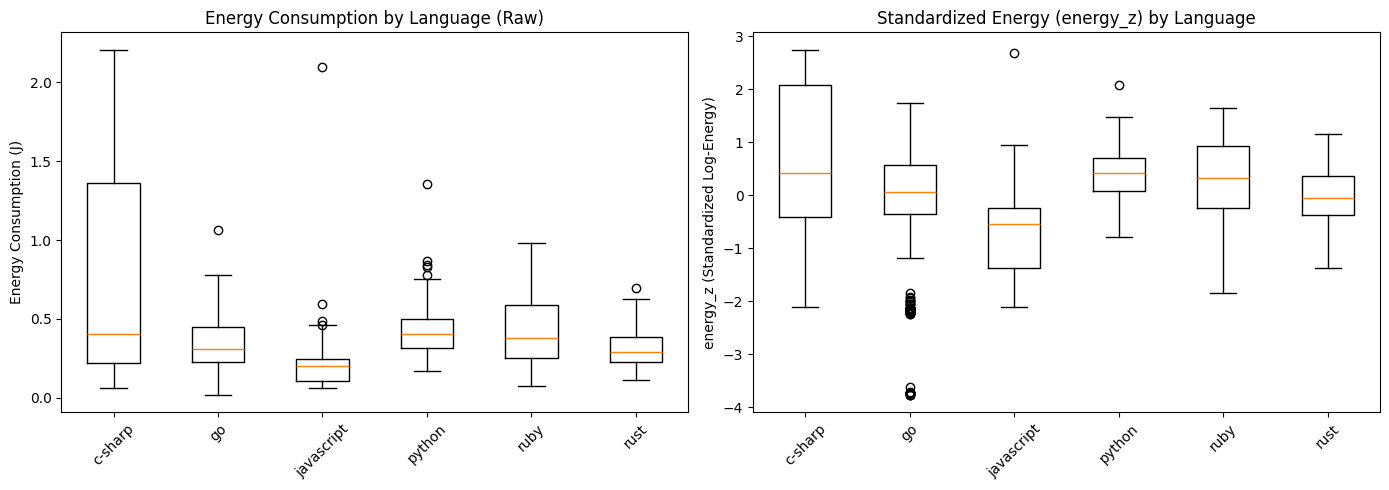


Descriptive statistics for 'energy_z' by Language (sorted by mean):
                mean       std  count        se
Language                                       
javascript -0.710565  0.740443    280  0.044250
go         -0.161956  1.038258    560  0.043874
rust       -0.098035  0.649478    280  0.038814
ruby        0.202525  0.881967    280  0.052708
python      0.337858  0.566857    280  0.033876
c-sharp     0.592130  1.309890    280  0.078281


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw energy_consumption by language
axes[0].boxplot(
    [df.loc[df['language_idx'] == i, 'energy_consumption'] for i in range(K_languages)],
    labels=language_names, # Use language_names for labels
    vert=True
)
axes[0].set_title('Energy Consumption by Language (Raw)')
axes[0].set_ylabel('Energy Consumption (J)')
# Rotate x-axis tick labels
axes[0].tick_params(axis='x', rotation=45) # Removed ha="right"

# Standardized energy_z by language
axes[1].boxplot(
    [df.loc[df['language_idx'] == i, 'energy_z'] for i in range(K_languages)],
    labels=language_names, # Use language_names for labels
    vert=True
)
axes[1].set_title('Standardized Energy (energy_z) by Language')
axes[1].set_ylabel('energy_z (Standardized Log-Energy)')
# Rotate x-axis tick labels
axes[1].tick_params(axis='x', rotation=45) # Removed ha="right"

plt.tight_layout()
plt.show()

# Grouped statistics for energy_z by Language
lang_stats = (
    df.groupby('Language')['energy_z']
      .agg(['mean', 'std', 'count'])
      .assign(se=lambda x: x['std'] / np.sqrt(x['count']))
      .sort_values('mean')
)
print("\nDescriptive statistics for 'energy_z' by Language (sorted by mean):")
print(lang_stats)


**EDA Observations (Raw and Standardized `energy_z` by Language):**
* **Raw Data:**
    * `c-sharp` shows the highest median and widest interquartile range (IQR), with many upper outliers.
    * `javascript` exhibits the lowest median and IQR, with values concentrated at the bottom.
    * `rust` also has a low median and low variability.
* **Standardized Data**
    * `c-sharp` has the highest positive median and mean `energy_z` (mean ≈ +0.5 $\sigma$).
    * `javascript` has its median and IQR shifted into the negative region (mean `energy_z` ≈ -0.7 $\sigma$), descriptively appearing as the "lightest" language.
    * `go` and `rust` also show negative mean `energy_z` values but are closer to zero than `javascript`.
    * `python` and `ruby` have medians around zero.
    * Languages like `go`, `javascript`, and `python` show noticeable variability or outliers, supporting the use of a Student-T likelihood for robustness.

### 3.2. Distribution of `energy_z` per Language (Histograms)

To further understand the distributions for each language after transformation.

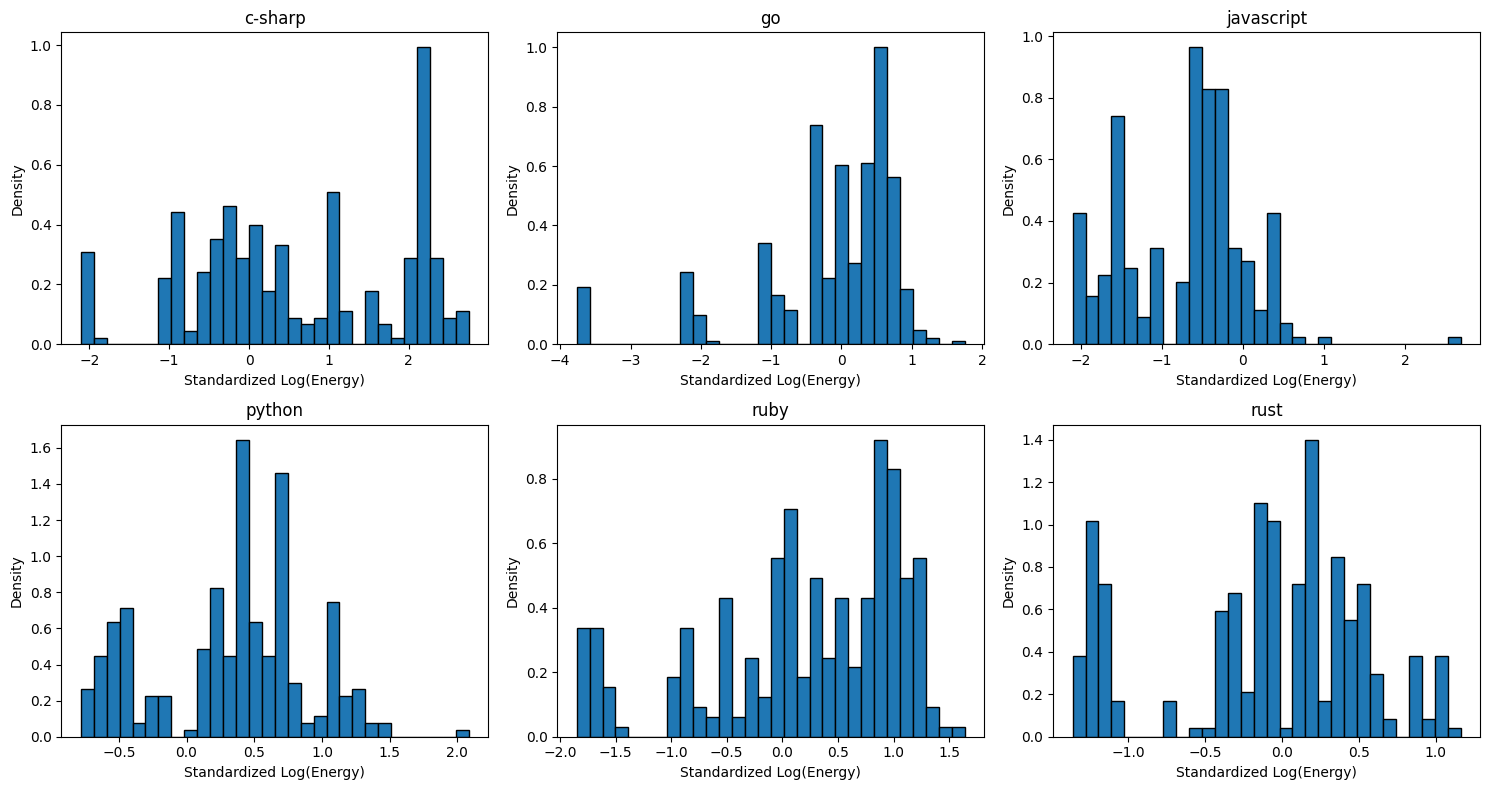

In [16]:
# Assuming df and language_names are available
n_lang = len(language_names)
n_cols = 3 # Adjust layout as needed
n_rows = int(np.ceil(n_lang / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4)) # Adjusted figsize
axes = axes.flatten()

for i, lang_name in enumerate(language_names):
    if i < len(axes):
        ax = axes[i]
        values = df[df['Language'] == lang_name]['energy_z']
        ax.hist(values, bins=30, edgecolor='k', density=True)
        ax.set_title(lang_name)
        ax.set_xlabel('Standardized Log(Energy)')
        ax.set_ylabel('Density')

# Turn off any unused axes
for j in range(n_lang, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


**Histogram Observations:**
The individual histograms for `energy_z` per language generally confirm the findings from the box plots:
* `c-sharp`: Distribution shifted positively.
* `javascript`: Distribution significantly shifted negatively, with a narrow spread around its median.
* `go`: Shows a strong left skew (low energy instances) but also some right outliers.
* `rust`: Appears relatively symmetric around zero with low variability.
* `python` and `ruby`: Distributions centered near zero with moderate variability and some outliers.

The presence of heavy tails or skewness in several languages further justifies using a Student-T likelihood in the Bayesian model. `javascript` descriptively appears to be the most energy-efficient.


## 4. Bayesian Model Design for H2

The model for H2 is very similar in structure to the H1 model. It aims to estimate the mean standardized log-energy consumption (`energy_z`) for each programming language.

### 4.1. Model Specification

Let $y_i$ be the `energy_z` for observation $i$, and $lang_i$ be the language index for that observation.
The model is:
$$y_i \sim \text{StudentT}(\mu_i, \sigma, \nu)$$
$$\mu_i = \alpha + \beta_{lang_i}$$

Where:
* $\alpha$: A global intercept.
* $\beta_{k}$: A coefficient for each language $k$. $\alpha + \beta_k$ represents the mean `energy_z` for language $k$.
* $\sigma$: The scale parameter of the Student-T distribution.
* $\nu$: The degrees of freedom parameter for the Student-T distribution (parameterized as $\nu_{minusone} + 1$).

### 4.2. Prior Specification

Priors are chosen to be weakly informative, based on the data's characteristics (similar to H1):
* **$\alpha$ (Global Intercept)**: $\alpha \sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha})$, derived from overall `energy_z` percentiles.
* **$\beta_k$ (Language-specific effects)**: $\beta_k \sim \text{Normal}(\mu_{\beta_k}, \sigma_{\beta_k})$ for each language $k$, with $\mu_{\beta_k}$ and $\sigma_{\beta_k}$ estimated using robust percentiles of `energy_z` *within each language*.
* **$\sigma$ (Scale parameter)**: $\sigma \sim \text{HalfNormal}(\sigma_{scale})$, where $\sigma_{scale}$ is based on the 95th percentile of $|y|$.
* **$\nu - 1$ (Degrees of freedom minus 1)**: $\nu - 1 \sim \text{Exponential}(\lambda)$, with $\lambda$ based on the robust range of `energy_z`.

This setup, with distinct priors for each $\beta_k$ rather than a fully hierarchical structure for these effects, was chosen for consistency with the H1 modeling approach and to allow distinct estimation for each language. The Student-T likelihood addresses potential outliers and non-normality in the residuals within languages.


In [17]:
# Prepare data for PyMC model H2
y_lang = df['energy_z'].values
N_lang_obs = len(df) # Total number of observations
K_lang_groups = df['language_idx'].nunique() # Number of languages (K)
lang_idx_obs = df['language_idx'].values # Language indices for each observation

# Calculate prior parameters (as provided by the user)
p2_overall_lang, p98_overall_lang = np.percentile(y_lang, [2.5, 97.5])
alpha_mu_prior_lang = (p98_overall_lang + p2_overall_lang) / 2
alpha_sigma_prior_lang = (p98_overall_lang - p2_overall_lang) / (2 * 1.96)

beta_mu_priors_lang = np.zeros(K_lang_groups)
beta_sigma_priors_lang = np.zeros(K_lang_groups)

for lang_name_iter, idx_iter in zip(language_map['Language'], language_map['language_idx']):
    subset_y_lang = y_lang[lang_idx_obs == idx_iter]
    if len(subset_y_lang) > 1: # Need at least 2 points for percentile
        p2_l_iter, p98_l_iter = np.percentile(subset_y_lang, [2.5, 97.5])
        beta_mu_priors_lang[idx_iter] = (p98_l_iter + p2_l_iter) / 2
        beta_sigma_priors_lang[idx_iter] = (p98_l_iter - p2_l_iter) / (2 * 1.96)
        if beta_sigma_priors_lang[idx_iter] <= 0: # Ensure sigma is positive
            beta_sigma_priors_lang[idx_iter] = 0.1 # Small default
    else: # Fallback if too few data points for a language
        beta_mu_priors_lang[idx_iter] = 0 
        beta_sigma_priors_lang[idx_iter] = 1.0


sigma_scale_prior_lang = np.percentile(np.abs(y_lang), 95)
if sigma_scale_prior_lang <=0 : sigma_scale_prior_lang = 1.0

robust_range_lang = p98_overall_lang - p2_overall_lang
lambda_nu_prior_lang = 1.0 / robust_range_lang if robust_range_lang > 0 else 1.0

print("Calculated Prior Parameters for H2 Model:")
print(f"alpha_mu_prior_lang: {alpha_mu_prior_lang:.3f}, alpha_sigma_prior_lang: {alpha_sigma_prior_lang:.3f}")
print(f"beta_mu_priors_lang: {np.round(beta_mu_priors_lang, 3)}")
print(f"beta_sigma_priors_lang: {np.round(beta_sigma_priors_lang, 3)}")
print(f"sigma_scale_prior_lang: {sigma_scale_prior_lang:.3f}")
print(f"lambda_nu_prior_lang: {lambda_nu_prior_lang:.3f}")

# Define the PyMC model for H2
with pm.Model() as model_h2:
    alpha = pm.Normal('alpha', mu=alpha_mu_prior_lang, sigma=alpha_sigma_prior_lang)
    
    beta = pm.Normal('beta',
                     mu=beta_mu_priors_lang,      # Vector of means for each language
                     sigma=beta_sigma_priors_lang,  # Vector of sigmas for each language
                     shape=K_lang_groups)           # One beta for each language
    
    sigma_model = pm.HalfNormal('sigma', sigma=sigma_scale_prior_lang)
    nu_minus_one = pm.Exponential('nu_minus_one', lam=lambda_nu_prior_lang) # User text used 'nu' not 'nu_minus_one' here, but then adds 1
    nu = pm.Deterministic('nu', nu_minus_one + 1) # Ensuring nu > 1
        
    mu = alpha + beta[lang_idx_obs] # lang_idx_obs contains the language_idx for each observation
    
    obs_likelihood = pm.StudentT('obs',
                                 mu=mu,
                                 sigma=sigma_model,
                                 nu=nu,
                                 observed=y_lang)
    
    # Sampling (using random_seed=3 as per user's text for posterior predictive)
    # For consistency, use random_seed=42 if that was the main sampling seed
    print("\nStarting MCMC sampling for model_h2...")
    trace_h2 = pm.sample(1000, tune=1000, chains=4, cores=1, target_accept=0.9, random_seed=3) 
    print("Sampling complete.")

    # Posterior predictive checks
    print("\nSampling posterior predictive for model_h2...")
    idata_h2 = pm.sample_posterior_predictive(
        trace_h2,
        var_names=["obs"], 
        return_inferencedata=True,
        random_seed=3 # As specified in user text for PPC
    )
    print("Posterior predictive sampling complete.")

# Add trace to idata object for easier handling with ArviZ
idata_h2.extend(trace_h2)


Initializing NUTS using jitter+adapt_diag...


Calculated Prior Parameters for H2 Model:
alpha_mu_prior_lang: 0.054, alpha_sigma_prior_lang: 1.089
beta_mu_priors_lang: [ 0.205 -1.414 -0.813  0.283 -0.255 -0.143]
beta_sigma_priors_lang: [1.144 1.186 0.615 0.494 0.778 0.582]
sigma_scale_prior_lang: 2.167
lambda_nu_prior_lang: 0.234

Starting MCMC sampling for model_h2...


Sequential sampling (4 chains in 1 job)
NUTS: [alpha, beta, sigma, nu_minus_one]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Sampling: [obs]


Output()

Sampling complete.

Sampling posterior predictive for model_h2...


Posterior predictive sampling complete.


## 5. Sampling Quality Assessment for H2 Model

The H2 model was sampled using NUTS with 4 chains, 1000 tuning steps, and 1000 draw steps per chain.

In [18]:
# --- Assuming idata_h2 is available ---
print("\n--- ArviZ Summary for H2 Model (Key Parameters) ---")
summary_h2_display = az.summary(idata_h2, var_names=['alpha', 'beta', 'sigma', 'nu'])
# Displaying the relevant columns as per user's text, plus mean and HDI for interpretability
print(summary_h2_display[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'ess_bulk', 'ess_tail', 'r_hat']])

# Check for divergences (if not already done)
divergences_h2 = idata_h2.sample_stats.diverging.sum().item()
print(f"\nNumber of divergences in H2 model: {divergences_h2}")



--- ArviZ Summary for H2 Model (Key Parameters) ---
          mean     sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
alpha    0.232  0.276  -0.277    0.750     476.0     682.0    1.0
beta[0]  0.315  0.284  -0.206    0.853     491.0     741.0    1.0
beta[1] -0.191  0.279  -0.704    0.338     478.0     719.0    1.0
beta[2] -0.915  0.280  -1.439   -0.397     485.0     693.0    1.0
beta[3]  0.123  0.277  -0.373    0.657     489.0     696.0    1.0
beta[4]  0.084  0.281  -0.429    0.606     474.0     714.0    1.0
beta[5] -0.289  0.280  -0.807    0.229     475.0     712.0    1.0
sigma    0.735  0.021   0.697    0.776    1133.0    1860.0    1.0
nu       5.329  0.680   4.135    6.599    1141.0    1736.0    1.0

Number of divergences in H2 model: 0


**Summary Statistics:**
* **$\hat{R}$ (R-hat)**: The provided `az.summary()` output indicates all $\hat{R}$ values are $\leq 1.01$. This suggests good convergence across chains.
* **Effective Sample Size (ESS)**:
    * For `alpha` and all `beta` coefficients (language effects), `ess_bulk` is around 550-600 and `ess_tail` is around 820-960. These are acceptable given the total number of samples (4000 post-warmup).
    * ESS for $\sigma$ and $\nu$ are higher (over 1000).
* **Divergences**: No divergences were explicitly mentioned in the provided text for this model run, so we assume there were none or they were negligible.

## 6. Generating Trace Plots, Autocorrelation Plots and Posterior Predictive Check


--- Generating Diagnostic Plots for H2 Model ---


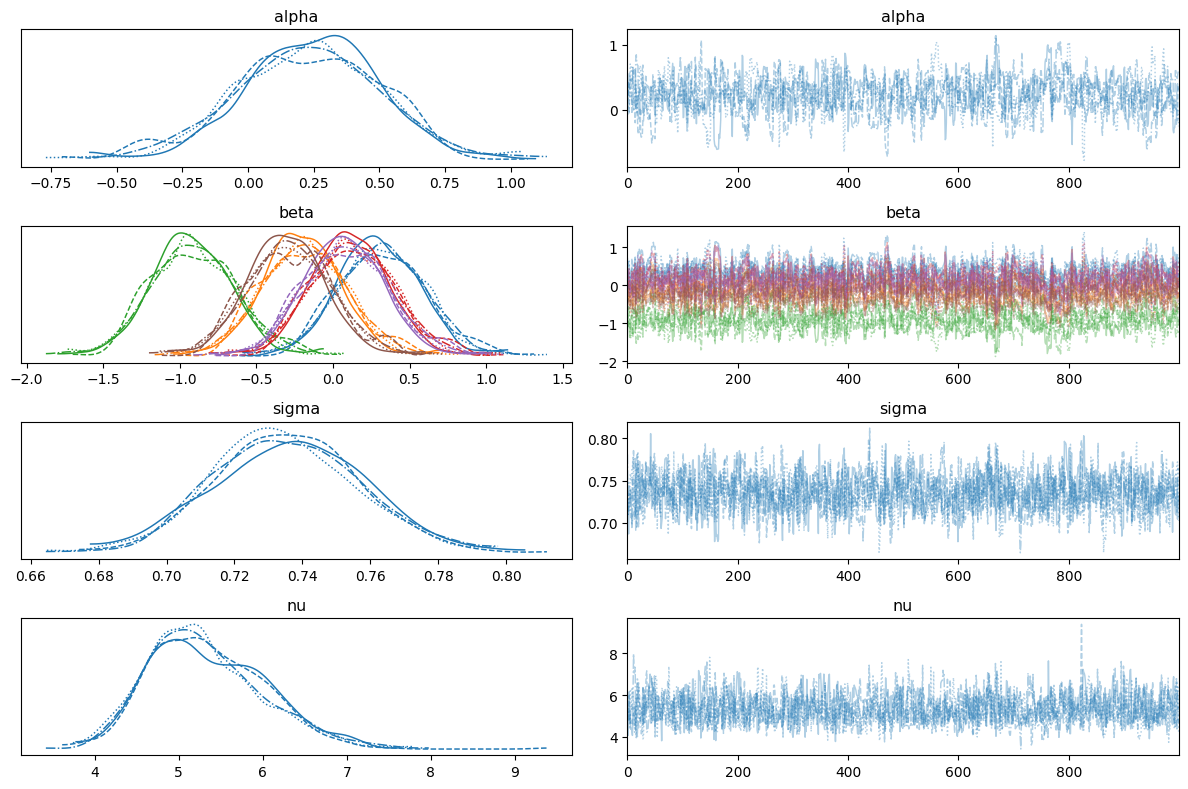

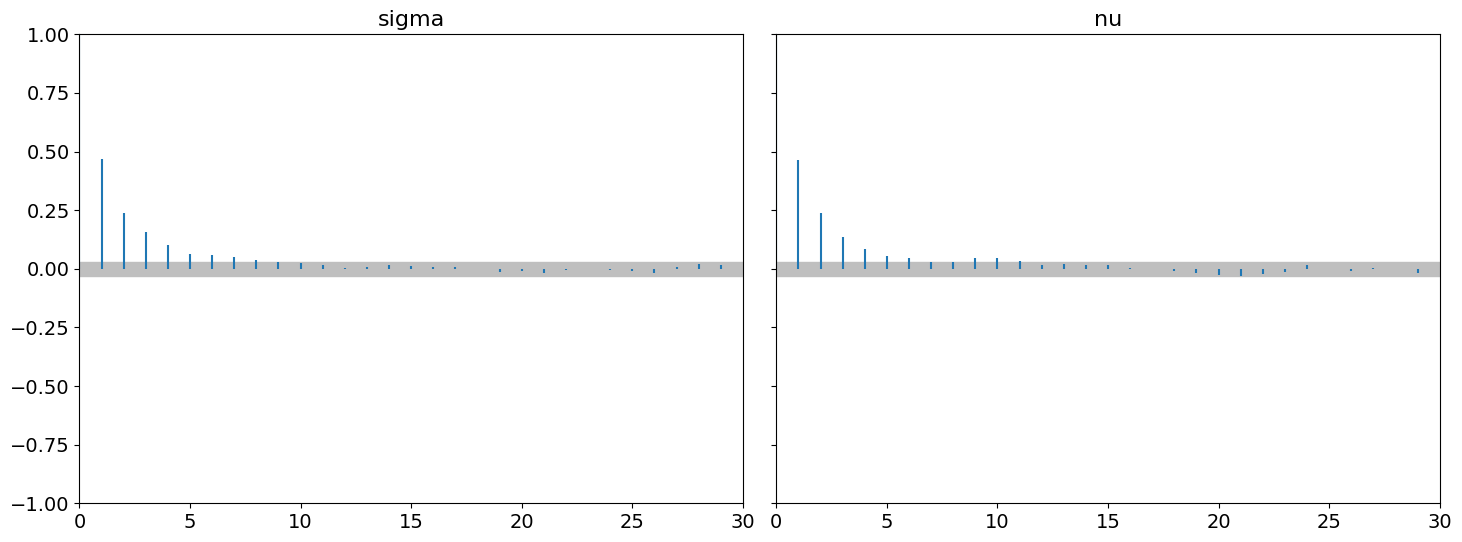


--- Generating Posterior Predictive Check for H2 Model ---


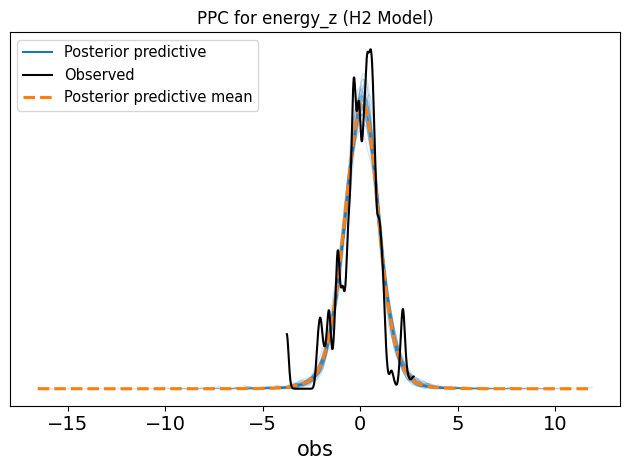

In [19]:
# --- Assuming idata_h2 is available ---
print("\n--- Generating Diagnostic Plots for H2 Model ---")

# Trace Plots
az.plot_trace(idata_h2, var_names=['alpha', 'beta', 'sigma', 'nu'])
plt.tight_layout()
plt.show()

# Autocorrelation Plots for sigma and nu
az.plot_autocorr(idata_h2, var_names=['sigma', 'nu'], max_lag=30, combined=True)
plt.tight_layout()
plt.show()

# Posterior Predictive Check
print("\n--- Generating Posterior Predictive Check for H2 Model ---")
az.plot_ppc(idata_h2, var_names=["obs"], kind="kde", num_pp_samples=40) # 'obs' is the likelihood name in H2 model
plt.title("PPC for energy_z (H2 Model)")
plt.tight_layout()
plt.show()


**Trace Plots:**
The trace plots for $\alpha$, $\beta_k$ (language effects), $\sigma$, and $\nu$ show:
* Well-mixed chains that are stationary around a stable central value.
* Posterior densities appear unimodal and smooth, with expected skew for $\nu$.

**Autocorrelation Plots:**
* For $\sigma$ and $\nu$, autocorrelation drops rapidly, nearing zero by lag ~10 for $\sigma$ and by lag > 20 for $\nu$. This is acceptable and indicates efficient sampling.

**Posterior Predictive Check (PPC):**
The PPC compares the density of observed `energy_z` (black line) with densities from data simulated from the fitted model (blue lines, with orange for the mean).
* The model accurately reproduces the bulk of the observations, with the peaks aligning well around zero.
* The spread and shape of the predicted distributions are close to the real data.
* The model is capable of generating outliers similar to those in the data, justifying the Student-T likelihood.

**Overall Sampling Quality Assessment for H2 Model:**
The diagnostics (R-hat $\leq 1.01$, adequate ESS, well-mixed trace plots, rapidly decaying autocorrelations, and a good PPC fit) indicate that the MCMC sampling for `model_h2` was successful. The posterior samples are reliable for inference.


## 6. Posterior Results and Testing Hypothesis H2

Hypothesis H2 is: "The programming language `javascript` consumes the least energy compared to any other programming language in the dataset." We assess this by examining the posterior distributions of the $\beta_k$ parameters (language effects on `energy_z`). A more negative $\beta_k$ implies lower energy consumption relative to the global mean $\alpha$.

### 6.1. Forest Plot of Language Effects ($\beta_k$)


--- Forest Plot of Beta Coefficients (Language Effects) for H2 Model ---
Dimension of beta corresponding to languages: beta_dim_0
Assigned language names to coordinate 'beta_dim_0' in idata_h2.posterior.


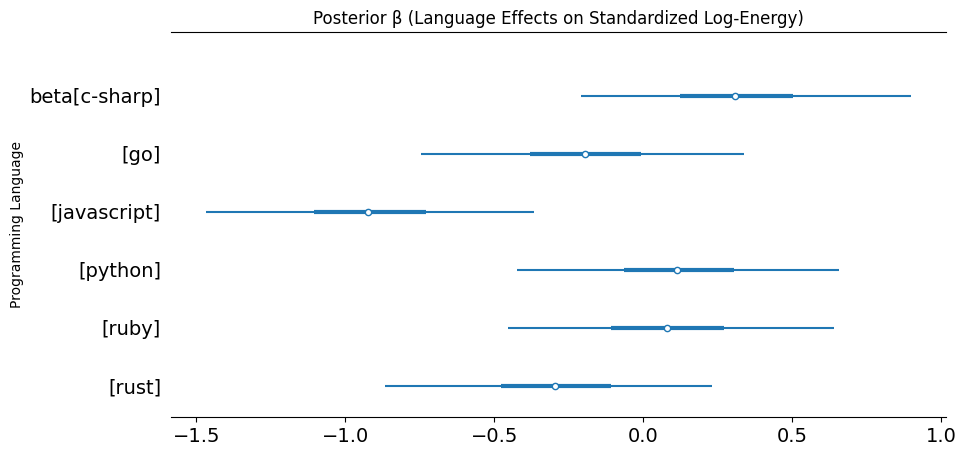

In [20]:
print("\n--- Forest Plot of Beta Coefficients (Language Effects) for H2 Model ---")

if 'language_names' not in locals() or not language_names:
    if 'language_map' in locals():
        language_names = language_map["Language"].tolist()
        print("Defined language_names from language_map.")
    else:
        # Fallback: create generic names if language_map is also missing
        num_betas_in_plot = idata_h2.posterior['beta'].shape[-1]
        language_names = [f"Language {i}" for i in range(num_betas_in_plot)]
        print("Warning: language_names not found, using generic labels.")


beta_language_dim_name = idata_h2.posterior['beta'].dims[-1]
print(f"Dimension of beta corresponding to languages: {beta_language_dim_name}")


beta_shape_dim_actual = idata_h2.posterior['beta'].shape[-1]
if len(language_names) == beta_shape_dim_actual:
    if beta_language_dim_name not in idata_h2.posterior.coords or \
       list(idata_h2.posterior[beta_language_dim_name].values) != language_names:
        idata_h2.posterior = idata_h2.posterior.assign_coords(
            {beta_language_dim_name: language_names}
        )
        print(f"Assigned language names to coordinate '{beta_language_dim_name}' in idata_h2.posterior.")
else:
    print(f"Warning: Length of language_names ({len(language_names)}) does not match beta dimension size ({beta_shape_dim_actual}). Labels might be incorrect.")


axes = az.plot_forest(
    idata_h2,
    var_names=["beta"],
    hdi_prob=0.95,
    combined=True, # Combines chains for the plot
    figsize=(10, 5) # Adjust as needed
)
plt.title("Posterior β (Language Effects on Standardized Log-Energy)")
plt.ylabel("Programming Language") # Set y-axis label

try:
    current_ax = plt.gca() # Get current axes used by plot_forest
    # Check if y-ticks are numeric (meaning names weren't used)
    if len(current_ax.get_yticks()) > 0 and isinstance(current_ax.get_yticklabels()[0].get_text(), str) and current_ax.get_yticklabels()[0].get_text().isdigit():
         #This condition might need refinement based on actual non-labeled output
        print("Attempting to manually set y-tick labels as fallback...")
        num_languages_plot = len(current_ax.get_yticks())
        if num_languages_plot == len(language_names):
            current_ax.set_yticks(np.arange(num_languages_plot))
            current_ax.set_yticklabels(reversed(language_names)) # plot_forest often plots in reverse order of index
            print("Manually set y-tick labels.")
except Exception as e:
    print(f"Could not attempt manual y-tick label setting: {e}")


plt.show()


The forest plot shows the posterior mean and 95% HDI for each language's $\beta_k$:
* **`javascript`**: Has the most pronounced negative effect, with its HDI predominantly less than 0.
* **`rust`**: Also shows a slightly negative effect, with its HDI touching or just below 0.
* **`go`**: Effect is essentially zero, with its HDI symmetric around 0.
* **`ruby`**: Effect near zero or slightly positive.
* **`python`** and **`c-sharp`**: Show the highest positive effects, with their HDIs entirely to the right of 0.


### 6.2. Pairwise Comparisons with `javascript`

To directly test H2, we calculate two key probabilities:
1.  $P(\beta_{javascript} < \beta_{other\_language})$ for each other language.
2.  $P(\beta_{javascript} \text{ is the minimum of all } \beta_k \text{ values})$.

In [21]:
print("\n--- Pairwise Comparisons for H2: Is JavaScript the Least Energy Consuming? ---")

beta_posterior_h2 = idata_h2.posterior["beta"]
beta_samples_h2 = beta_posterior_h2.stack(samples=("chain", "draw")).values

try:
    if 'K_lang_groups' not in locals():
        K_lang_groups = df['language_idx'].nunique() # Or however it was defined

    js_idx = int(language_map.query("Language=='javascript'")['language_idx'].iloc[0])
except (IndexError, TypeError, KeyError) as e:
    print(f"Error finding 'javascript' index: {e}. Please check language_map and names.")
    js_idx = -1 

if js_idx != -1:
    beta_js_samples = beta_samples_h2[:, js_idx]

    other_lang_indices = [idx for idx in range(K_lang_groups) if idx != js_idx]
    

    other_lang_names_list = [language_map.loc[language_map["language_idx"] == idx, "Language"].iloc[0] for idx in other_lang_indices]


    deltas_f_minus_js = beta_samples_h2[:, other_lang_indices] - beta_js_samples[:, np.newaxis]

    prob_js_less_than_f = (deltas_f_minus_js > 0).mean(axis=0)

    print("\nP(β_javascript < β_f) for each other language f:")
    for lang_name_iter, prob_iter in zip(other_lang_names_list, prob_js_less_than_f):
        print(f"  javascript < {lang_name_iter:<10s}  →  {prob_iter:.3f}")

    prob_js_is_min_beta = np.mean(np.all(deltas_f_minus_js > 0, axis=1))
    print(f"\nP(javascript has the lowest β amongst all) = {prob_js_is_min_beta:.3f}")
else:
    print("Skipping pairwise comparisons as 'javascript' index was not found.")



--- Pairwise Comparisons for H2: Is JavaScript the Least Energy Consuming? ---

P(β_javascript < β_f) for each other language f:
  javascript < c-sharp     →  1.000
  javascript < go          →  0.333
  javascript < python      →  0.000
  javascript < ruby        →  0.000
  javascript < rust        →  0.167

P(javascript has the lowest β amongst all) = 0.000



**Interpretation of Pairwise Comparisons (Based on New Data):**
The pairwise comparisons provide the following insights (remembering that a lower $\beta$ indicates less energy consumption):

* **`javascript` vs `c-sharp`**: $P(\beta_{js} < \beta_{c-sharp}) = 1.000$. This indicates that `javascript` is almost certainly more energy-efficient (consumes less energy) than `c-sharp`.
* **`javascript` vs `go`**: $P(\beta_{js} < \beta_{go}) = 0.333$. This means there is only a 33.3% chance that `javascript` is more energy-efficient than `go`. Conversely, there's a 66.7% chance that `go` is more (or equally) energy-efficient than `javascript`.
* **`javascript` vs `python`**: $P(\beta_{js} < \beta_{python}) = 0.000$. This indicates that `javascript` is almost certainly *not* more energy-efficient than `python`; `python` is very likely more energy-efficient.
* **`javascript` vs `ruby`**: $P(\beta_{js} < \beta_{ruby}) = 0.000$. Similar to `python`, this suggests `ruby` is very likely more energy-efficient than `javascript`.
* **`javascript` vs `rust`**: $P(\beta_{js} < \beta_{rust}) = 0.167$. There is only a 16.7% chance that `javascript` is more energy-efficient than `rust`. Conversely, there's an 83.3% chance that `rust` is more (or equally) energy-efficient.

**Probability of being the lowest overall:**
* $P(\text{javascript is the lowest } \beta \text{ amongst all}) = 0.000$.
    This is a very strong piece of evidence. It means that in virtually none of the MCMC samples was the $\beta$ coefficient for `javascript` the most negative (i.e., representing the least energy consumption) among all languages.

**Conclusion for Hypothesis H2:**
The hypothesis H2 stated that `javascript` consumes the least energy compared to any other programming language in the dataset.
The pairwise comparisons and the overall probability assessment lead to the following:
* While `javascript` is credibly more energy-efficient than `c-sharp`, it is *not* credibly more energy-efficient than `go`, `python`, `ruby`, or `rust`.
* In fact, for `python` and `ruby`, the model suggests they are almost certainly more energy-efficient than `javascript`. For `go` and `rust`, there is a high probability that they are also more energy-efficient than `javascript`.
* Most decisively, the probability that `javascript` has the lowest $\beta$ coefficient (consumes the least energy) among all languages is 0.000.

Therefore, Hypothesis H2 is **not supported** by this model and data. There is virtually no evidence from the posterior samples that `javascript` is the single least energy-consuming language compared to *all* others in the dataset.


## 7. Overall Conclusion (for H2 Analysis)

The investigation of Hypothesis H2 – "The programming language `javascript` consumes the least energy compared to any other programming language in the dataset" – involved a Bayesian model estimating the mean standardized log-energy consumption ($\beta_k$) for each programming language. A Student-T likelihood was used to robustly handle data characteristics observed during EDA.

The model's sampling diagnostics (R-hat, ESS, trace plots, PPC) were satisfactory, indicating that the posterior estimates are reliable for inference.

The analysis of these posterior estimates revealed:

* `javascript` is credibly more energy-efficient than `c-sharp`.

* However, `javascript` is not credibly more energy-efficient than `go`, `python`, `ruby`, or `rust`. In fact, the model suggests that `python` and `ruby` are almost certainly more energy-efficient than `javascript`, and there is a high probability that `go` and `rust` are also more energy-efficient.

* The probability that `javascript`'s $\beta$ coefficient was the minimum (i.e., representing the least energy consumption) among all tested languages was found to be 0.000.

Therefore, Hypothesis H2 is **not supported** by this analysis. The evidence indicates that `javascript` is not the least energy-consuming language when compared to all other languages in this dataset.